## Modeling driving transit times in Seattle

This notebook uses driving data collected from [movement.uber.com](https://movement.uber.com) and distance data calculated from an AWS-hosted [OSRM server](http://project-osrm.org/) to predict transit times. See preprocessing notebook for data preparation.

### Mount Google drive as storage




In [135]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import modules



In [0]:
from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from fastai.tabular import *

from keras.optimizers import Adadelta
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

import json


### Load csv with driving and OSRM distance data

In [137]:
# load csv as dataframe
path = Path('/content/gdrive/My Drive/Python/ubermovement/data')
df = pd.read_csv(path/'df3_with_distances_final.csv')

# preview the dataframe
df.head()

,Unnamed: 0,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,src_lat,src_lon,dst_lat,dst_lon,distance
0,0,719,27,3,1670.75,643.48,1577.05,1.38,47.870603,-122.203015,47.730525,-122.332923,14.540743
1,1,365,149,5,1073.65,480.03,982.73,1.51,47.685120,-122.349925,47.622924,-122.324658,5.502815
2,2,775,717,3,1617.82,226.10,1601.29,1.16,48.085921,-122.174539,47.806039,-122.246657,22.603614
3,3,365,389,6,413.17,164.40,386.37,1.43,47.685120,-122.349925,47.706727,-122.366497,2.244150
4,4,379,249,6,1379.37,384.10,1334.59,1.28,47.386275,-122.231370,47.632713,-122.173700,19.829247


#### Clean up data using conclusions from proprocessing analysis

In [0]:
# drop extra index column and a highly correlated/redundant travel time column
df = df.drop(['Unnamed: 0', 'geometric_mean_travel_time'], axis=1)

In [139]:
# drop a few rows with nan
count_nan = np.count_nonzero(df.isnull().values)
print('{} missing values in dataset containing {} rows\n'.format(count_nan, len(df)))
if count_nan:
  print(df.isnull().sum())
  
# since distance is an important predictor of 'mean_travel_time' and only a few rows are missing, drop them
print('\nDropping rows with nan:')
df.dropna(inplace=True)
count_nan = np.count_nonzero(df.isnull().values)
print('{} missing values in dataset containing {} rows'.format(count_nan, len(df)))

5 missing values in dataset containing 540004 rows

sourceid                                    0
dstid                                       0
dow                                         0
mean_travel_time                            0
standard_deviation_travel_time              0
geometric_standard_deviation_travel_time    0
src_lat                                     0
src_lon                                     0
dst_lat                                     0
dst_lon                                     0
distance                                    5
dtype: int64

Dropping rows with nan:
0 missing values in dataset containing 539999 rows


In [140]:
# drop lat/lon columns (use 'sourceid' and 'distid')
df = df.drop(['src_lat','src_lon','dst_lat', 'dst_lon'], axis=1)

df.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_standard_deviation_travel_time,distance
0,719,27,3,1670.75,643.48,1.38,14.540743
1,365,149,5,1073.65,480.03,1.51,5.502815
2,775,717,3,1617.82,226.10,1.16,22.603614
3,365,389,6,413.17,164.40,1.43,2.244150
4,379,249,6,1379.37,384.10,1.28,19.829247


In [141]:
# check data types
df.dtypes

sourceid                                      int64
dstid                                         int64
dow                                           int64
mean_travel_time                            float64
standard_deviation_travel_time              float64
geometric_standard_deviation_travel_time    float64
distance                                    float64
dtype: object

### Baseline models

#### Median value prediction

In [142]:
# Make predictions using median value for trip time

# get array of travel times and split into 'training' and testing sets
travel_times = df['mean_travel_time'].values
yTrain, yTest = train_test_split(travel_times, test_size=0.2, random_state=42)

# get median value of travel times and find MAE of test set
prediction = np.median(yTrain)
abs_err = abs(yTest - prediction)
mae_med = np.mean(abs_err)

print('Mean Absolute Error using median prediction: {}'.format(round(mae_med, 2)))

Mean Absolute Error using median prediction: 446.02


#### Linear Regression

In [143]:
# Multivariate Linear Regression

# define categorical and numeric features
cat_feat = ['sourceid', 'dstid', 'dow']
num_feat = ['distance']
cat_hash = [col + '_hash' for col in cat_feat]

# there are too many categorical values to one hot encode (curse of dimensionality)
# use hash trick instead

df_hash = df.copy()
max_size = 100

fh = FeatureHasher(n_features=max_size, input_type='string')

# hash categorical features and add to df_hash
for i in range(len(cat_feat)):
  feat_hash = fh.fit_transform( df_hash[cat_feat[i]].astype(str) )  # hash of feature
  cols = [cat_feat[i] + 'h' + str(j) for j in range(max_size)]      # create names for hash columns
  df_temp = pd.DataFrame(feat_hash.toarray(), columns=cols)         # create temp dataframe of hash
  df_hash = pd.concat([df_hash, df_temp], axis=1)                   # append to main dataframe

# drop columns used for hashing
df_hash.drop(cat_feat, axis=1, inplace=True)

# feature hashing creates several nan rows; since there are only a few, just remove them
print('{} nan values in target\n'.format(np.sum(np.isnan(df_hash['mean_travel_time']))))
print('Removing nan rows:')
df_hash.dropna(inplace=True)
print('{} nan values in target'.format(np.sum(np.isnan(df_hash['mean_travel_time']))))

5 nan values in target

Removing nan rows:
0 nan values in target


In [144]:
# create target and feature arrays from dataframe
y = df_hash['mean_travel_time'].values
X = df_hash.drop('mean_travel_time', axis=1).values

# normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# split data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the regression model
lr = LinearRegression()
lr.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [145]:
# generate predictions on test data and calculate MAE
y_pred = lr.predict(xTest)
mae_lr = metrics.mean_absolute_error(yTest,y_pred)
print('Mean Absolute Error using linear regression: {}'.format(round(mae_lr, 2)))

Mean Absolute Error using linear regression: 166.03


#### Random forest regression

In [146]:
# note that we are using 'mse' to optimize since 'mae' is prohibitively slow
# see https://github.com/scikit-learn/scikit-learn/issues/9626

rfreg = RandomForestRegressor(n_estimators=10, random_state=42, verbose=0, n_jobs=-1)
rfreg.fit(xTrain, yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [147]:
# generate predictions for test data and calculate MAE
y_pred = rfreg.predict(xTest)
mae_rf = metrics.mean_absolute_error(yTest, y_pred)
print('Mean Absolute Error using random forest: {}'.format(round(mae_rf, 2)))

Mean Absolute Error using random forest: 93.16


#### Random forest grid search

In [0]:
# Random forest regression fits with the lowest MAE
# Try performing a grid search to optimize hyperparameters

print('Current RF parameters:\n')
pprint(reg.get_params())

Current RF parameters:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [29]:
# limit hyperparameter options since modeling is slow
param_grid = { 
    'n_estimators': [10, 50],
    'max_features': ['sqrt', 'auto'], # 6 total features
    'max_depth' : [3, 10, 50]
}

# perform cross-validated grid search
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
CV_rfr.fit(xTrain, yTrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 12.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 10, 50],
       

In [34]:
# We won't tune hyperparameters further due to long processing time; 
# the takeaway in this case is that more features/estimators/depth perform better
CV_rfr.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [151]:
# the grid search suggests using more estimators
rfreg = RandomForestRegressor(n_estimators=50, random_state=42, verbose=0, n_jobs=-1)
rfreg.fit(xTrain, yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [152]:
# generate predictions for test data and calculate MAE
y_pred = rfreg.predict(xTest)
mae_rf_best = metrics.mean_absolute_error(yTest, y_pred)
print('Mean Absolute Error using random forest: {} ({}% improvement)'.format(round(mae_rf_best, 2), round((mae_rf - mae_rf_best)/mae_rf*100, 2)))


Mean Absolute Error using random forest: 89.56 (3.86% improvement)


In [150]:
mae_rf_best

93.16129371568256

Increasing the number of estimators from 10 to 50 lowers the MAE by ~4% but takes much longer to train. This might be worth it in some cases, but let's next try using neural networks.

### Neural Networks

#### Fastai with PyTorch

In [8]:
# set up fastai for Google Colab environment
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# split dataframe into train and test sets (90/10 split)

# create bool mask to apply random uniform selection of df for training
msk = np.random.rand(len(df)) < 0.9
df_train = df[msk]
df_test = df[~msk]

In [10]:
# include these preprocessing steps
procs = [Categorify, Normalize]

# set validation data range within training set
val_pct = 0.1
valid_idx = range(len(df_train) - round( val_pct*len(df_train) ), len(df_train))

# define dependent (target), categorical, and continuous variables
dep_var = 'mean_travel_time'
cat_names = ['dow','sourceid', 'dstid']
cont_names = ['distance', 'standard_deviation_travel_time', 'geometric_standard_deviation_travel_time']

# create a databunch
#data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)

# test tabular list
test = TabularList.from_df(df_test, cat_names=cat_names, cont_names=cont_names, procs=procs)

# train data bunch
data = (TabularList.from_df(df_train, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_idx(valid_idx)
                        .label_from_df(cols=dep_var)
                        .add_test(test) # remove this from model; apply test after export and reload
                        .databunch(bs=1024))

# show continuous var names (excluding target)
cont_names = data.train_ds.cont_names
print(data.train_ds.cont_names, '\n')

# preview a few rows of one data batch with 'procs' applied
data.show_batch(rows=5)

['distance', 'standard_deviation_travel_time', 'geometric_standard_deviation_travel_time'] 



dow,sourceid,dstid,distance,standard_deviation_travel_time,geometric_standard_deviation_travel_time,target
2,350,227,-0.4455,0.5871,0.1327,1103.2
3,655,656,-1.1335,-0.6290,5.5171,313.52
1,191,23,-0.2658,0.2228,0.0646,1028.08
6,366,306,-1.2177,-0.9031,1.4618,267.39
5,671,651,-0.6247,-0.0466,0.1668,899.14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


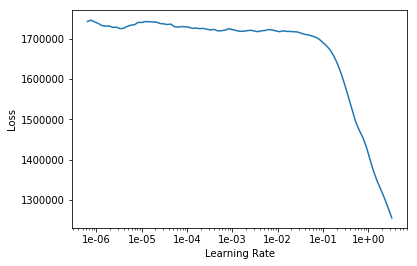

In [17]:
# initialize learner
learn = tabular_learner(data, layers=[200,100], metrics=mean_absolute_error, callback_fns=ShowGraph)

# create plot to select appropriate learning rate
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,25762.410156,16604.824219,96.942650,00:14
1,10863.067383,15751.506836,96.084465,00:14
2,11086.836914,20900.531250,115.305099,00:15
3,10386.590820,8920.645508,69.483734,00:15
4,10803.862305,9797.323242,75.316353,00:15
5,9558.250977,10873.405273,80.334129,00:15
6,8950.358398,10229.153320,75.757034,00:15
7,8402.222656,8639.273438,68.353279,00:15
8,7913.709961,489397.062500,81.166977,00:15
9,7214.141602,6891.637207,60.724457,00:14


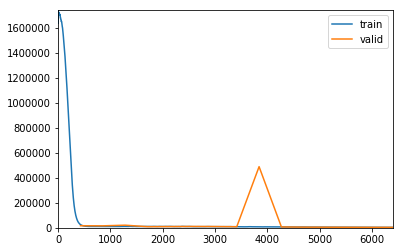

In [18]:
# fit model using selected learning rate
learn.fit_one_cycle(15, max_lr=2e-1)

In [0]:
# export the model
if False:
  learn.export('model_epoch_15_mae_42.pkl')

In [0]:
# reload model for use with test data
learn = load_learner(path, 'model_epoch_15_mae_42.pkl', test=df_test)

In [49]:
# use model for predictions on test data
y_test = df_test['mean_travel_time']
X_test = df_test.drop('mean_travel_time', axis=1)

# predict one item
row = 5
pred_val = learn.predict(X_test.iloc[row])[0].data[0]

print('Features:\n')
print(X_test.iloc[5], '\n')
print('mean_travel_time prediction: {}'.format(round(pred_val.astype('float'),2)))
print('mean_travel_time target:     {}'.format(y_test.iloc[row]))

Features:

sourceid                                    666.00000
dstid                                        89.00000
dow                                           4.00000
standard_deviation_travel_time              770.84000
geometric_standard_deviation_travel_time      1.44000
distance                                     21.80136
Name: 58, dtype: float64 

mean_travel_time prediction: 1691.43
mean_travel_time target:     1639.29


In [118]:
# make predictions for test set

# create test tabular list
tabList = TabularList.from_df(df_test, cat_names=cat_names, cont_names=cont_names, procs=procs)

# reload model for use with tabList test set and get predictions
learn = load_learner(path, 'model_epoch_15_mae_42.pkl', test=tabList)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

# calculate mae for test set
preds_np = preds.numpy().ravel()
targets = y_test.values.astype('float32')
mae_nn = np.mean(abs(preds_np - targets)).astype('float')
print('Mean Absolute Error using fastai neural net: {}'.format(round(mae_nn, 2)))

Mean Absolute Error using fastai neural net: 37.98


#### Keras sequential model

In [63]:
# split training set into training and validation (reserve test set)
xTrain_partial, x_val, yTrain_partial, y_val = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

# build sequential model
model = Sequential()
model.add(Dense(500, input_shape=(xTrain_partial.shape[1],), kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

# compile model
model.compile(loss='mean_absolute_error', optimizer=Adadelta())

# add early stopping callback
useEarlyStopping = True
if useEarlyStopping:
  callbacks = [EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001)]
else:
  callbacks=None

# fit the model
history = model.fit(xTrain_partial,
                    yTrain_partial,
                    epochs=100,
                    verbose=1,
                    batch_size=1024,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Train on 345596 samples, validate on 86399 samples
Epoch 1/100
345596/345596 [==============================] - 3s 9us/step - loss: 534.3381 - val_loss: 611.0154
Epoch 2/100
345596/345596 [==============================] - 3s 8us/step - loss: 382.4815 - val_loss: 194.7999
Epoch 3/100
345596/345596 [==============================] - 3s 8us/step - loss: 292.2486 - val_loss: 367.3594
Epoch 4/100
345596/345596 [==============================] - 3s 8us/step - loss: 278.2095 - val_loss: 276.5358
Epoch 5/100
345596/345596 [==============================] - 3s 8us/step - loss: 264.7289 - val_loss: 296.5596
Epoch 6/100
345596/345596 [==============================] - 3s 8us/step - loss: 254.3581 - val_loss: 254.9961
Epoch 7/100
345596/345596 [==============================] - 3s 8us/step - loss: 244.2438 - val_loss: 273.8572
Epoch 8/100
345596/345596 [==============================] - 3s 8us/step - loss: 236.6796 - val_loss: 250.3918
Epoch 9/100
345596/345596 [==============================] - 

In [0]:
# save model and weights

# serialize model to JSON
model_json = model.to_json()
with open(path/'keras/keras_model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights(path/'keras/keras_model.h5')

In [121]:
# reload json and create model
json_open = open(path/'keras/keras_model.json', 'r')
json_file = json_open.read()
json_open.close()
model = model_from_json(json_file)

# load saved weights into model
model.load_weights(path/'keras/keras_model.h5')

# make a prediction using test data
test_sample = np.array([xTest[0,]]) # need this to set input to expected dimension
pred = model.predict(test_sample).ravel()[0]
targ = yTest[0]
print('mean_travel_time prediction: {}'.format(round(pred.astype('float'),2)))
print('mean_travel_time target:     {}'.format(targ))

mean_travel_time prediction: 3003.44
mean_travel_time target:     3021.64


In [153]:
# evaluate model on test set
model.compile(loss='mean_absolute_error', optimizer=Adadelta(), metrics=['mean_absolute_error'])
mae_keras = model.evaluate(xTest, yTest, verbose=0)[0]

print('Mean Absolute Error using keras neural net: {}'.format(round(mae_keras, 2)))

Mean Absolute Error using keras neural net: 86.92


Given the performance of the Fastai model, the Keras model likely has room for improvement.

### Summary of model performance

In [168]:
print('Mean Average Errors:\n')
print('{:<30} {:>10}'.format('Median prediction' ,round(mae_med, 2)))
print('{:<30} {:>10}'.format('Linear regression', round(mae_lr, 2)))
print('{:<30} {:>10}'.format('Random forest regression', round(mae_rf_best, 2)))
print('{:<30} {:>10}'.format('Neural Network (Fastai)', round(mae_nn, 2)))
print('{:<30} {:>10}'.format('Neural Network (Keras)', round(mae_keras, 2)))

Mean Average Errors:

Median prediction                  446.02
Linear regression                  166.03
Random forest regression            89.56
Neural Network (Fastai)             37.98
Neural Network (Keras)              86.92


The errors for each these models could be further reduced by additional hyperparameter tuning. However, the Fastai model shows the most promise, given its simplicity and fast training. Using mostly default parameters, it fits with 56% lower MAE on test data than the Keras model.